In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

import random

from sklearn.model_selection import train_test_split as tts

In [2]:
from function import *

load data

In [3]:
df = pd.read_csv('clean_data/target_df.csv')

In [4]:
df.head()

,timestamp,open,high,low,close,volume,datetime,max_close_change,target_bin,hr
0,1668988800000,16279.50,16295.00,16123.01,16268.73,14167.43968,2022-11-21 00:00:00,-3.806136,0,0
1,1668992400000,16268.12,16283.06,16191.00,16214.15,7872.39775,2022-11-21 01:00:00,-3.482329,0,1
2,1668996000000,16214.15,16219.99,15905.88,16010.70,23043.32117,2022-11-21 02:00:00,-2.255866,0,2
3,1668999600000,16010.31,16110.55,15897.15,16073.75,17133.07210,2022-11-21 03:00:00,-2.639272,0,3
4,1669003200000,16073.15,16319.00,16064.22,16149.97,18837.79424,2022-11-21 04:00:00,-3.098767,0,4


make consecuent series

In [10]:
def col_to_matrix(value_col: pd.Series, time_col: pd.Series, size: int) -> (np.ndarray, np.array):
    """
    Convert a series into matrix of given width so each row has consecuent values
    Also saves the time corresponding to each row
    Args:
        col: column with initial values
        time_col: column with time records
        size: width of the matrix
    Retruns:
        np.ndarray: matrix of given width, drops the remaining values
        np.array: array of time corresponding to each row
    """
    values = value_col.values
    matrix = np.lib.stride_tricks.sliding_window_view(values, size)
    times = time_col.values
    time_array = np.array(times[: len(matrix)])
    return matrix, time_array

In [5]:
close_matrix, close_timestamps = col_to_matrix(df['close'], df['timestamp'], 24)

In [6]:
#min max scaling
scaled_matrix = np.array([(row - row.min()) / (row.max() - row.min()) for row in close_matrix])

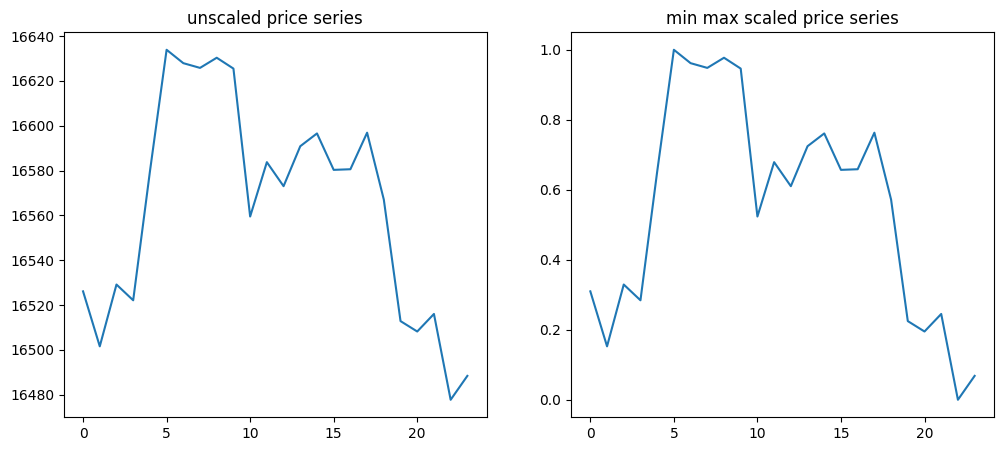

In [7]:
#ensure that series have same shape
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(close_matrix[116])
plt.title('unscaled price series')
plt.subplot(1,2,2)
plt.plot(scaled_matrix[116])
plt.title('min max scaled price series')
plt.show()

split to train val test sets

In [8]:
scaled_matrix.shape[0]

17894

In [9]:
full_size = scaled_matrix.shape[0]

train_matrix, val_matrix, train_stamps, val_stamps = tts(scaled_matrix[:int(full_size*0.9)], close_timestamps[:int(full_size*0.9)], random_state=116, test_size=0.2, shuffle=True)

test_matrix = scaled_matrix[int(full_size*0.9):]

convert to tensors

In [64]:
train_tensor = torch.tensor(train_matrix).type(torch.FloatTensor)
val_tensor = torch.tensor(val_matrix).type(torch.FloatTensor)
test_tensor = torch.tensor(test_matrix).type(torch.FloatTensor)

#### simple autoencoder

In [109]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, kernel):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 12),
            kernel,
            nn.Dropout(0.1),  # Dropout layer
            nn.Linear(12, 6),
            kernel,
            nn.Dropout(0.1),  # Dropout layer
            nn.Linear(6, 3),
            kernel,
            nn.Dropout(0.1),
            nn.Linear(3, 1),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(1, 3),
            kernel,
            nn.Linear(3, 6),
            kernel,
            nn.Linear(6, 12),
            kernel,
            nn.Linear(12, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [110]:
input_dim = 24
epochs = 1000
batch_size = 64
learning_rate = 0.01
patience = 10  # Early stopping patience

In [98]:
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)

In [99]:
def train_model(kernel):
    model = Autoencoder(input_dim, kernel)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    best_val_loss = float('inf')
    best_model_state = None
    train_losses = []
    val_losses = []
    early_stop_counter = 0
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch, in train_loader:
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
    
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
    
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch, in val_loader:
                outputs = model(batch)
                loss = criterion(outputs, batch)
                val_loss += loss.item()
    
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
    
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch + 1}.")
                break
    
    # Load best model state
    model.load_state_dict(best_model_state)
    model.eval()
    
    print('min val loss: {}'.format(min(val_losses) ** (1/2)))
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Curve")
    plt.legend()
    plt.show()

    return model

Early stopping triggered at epoch 39.
min val loss: 0.20976601722940527


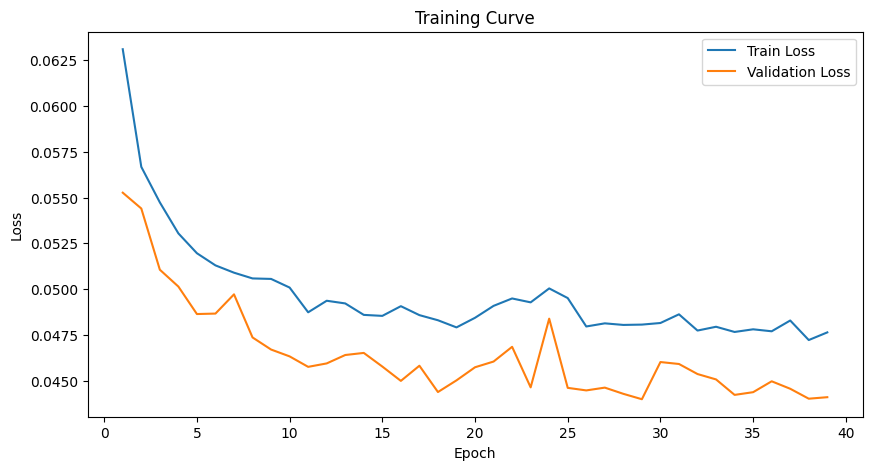

In [100]:
model = train_model(nn.LeakyReLU())

test results

In [21]:
model.eval()
with torch.no_grad():
    predictions = model(test_tensor)

In [23]:
criterion = nn.MSELoss()
criterion(test_tensor, predictions).item() ** (1/2)

0.21054517501116446

draw samples

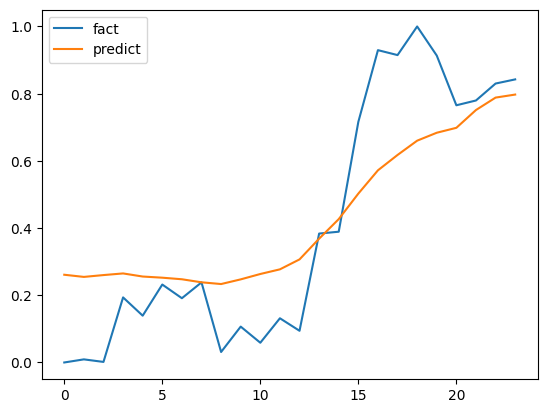

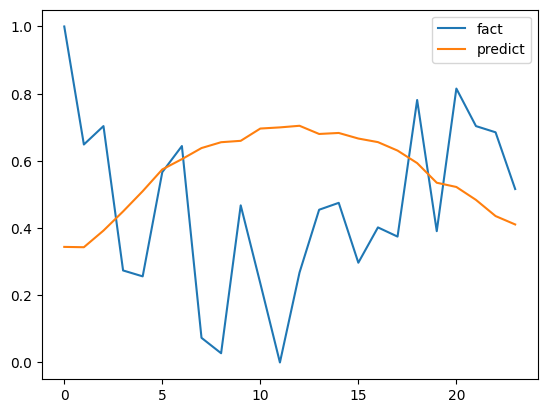

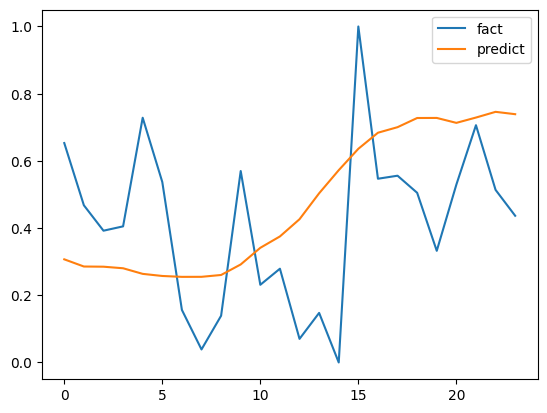

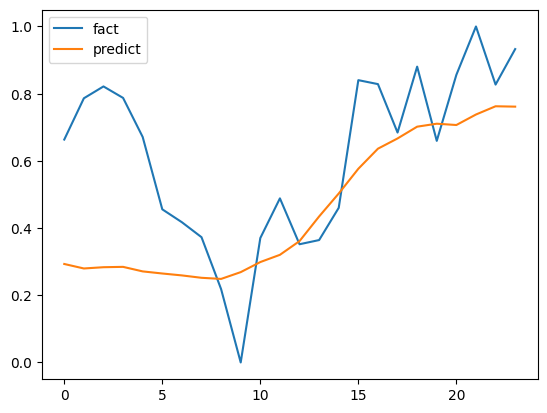

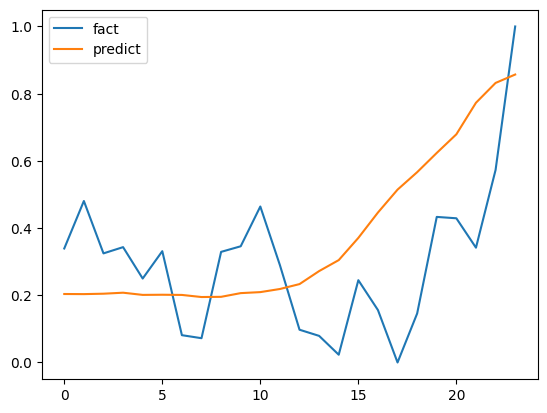

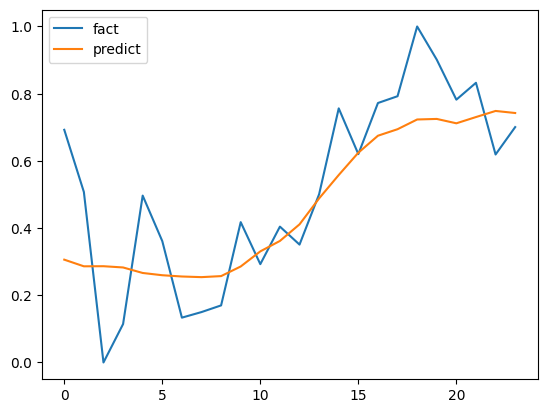

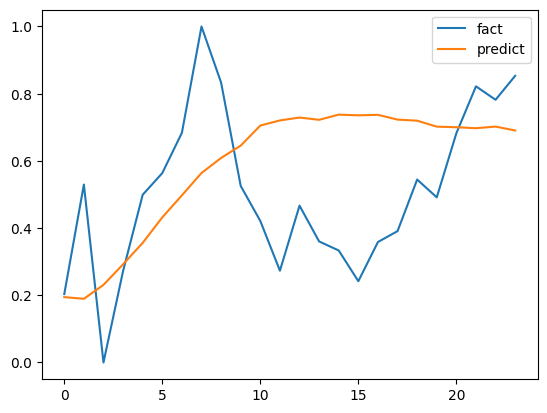

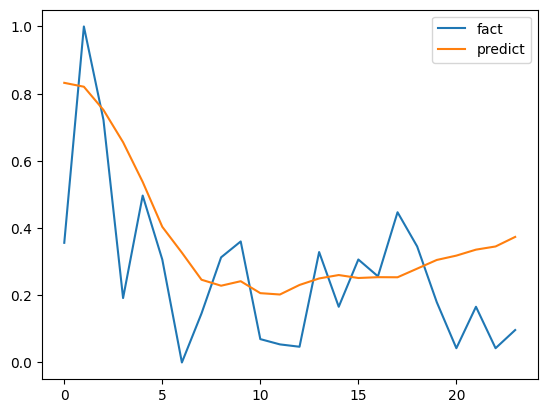

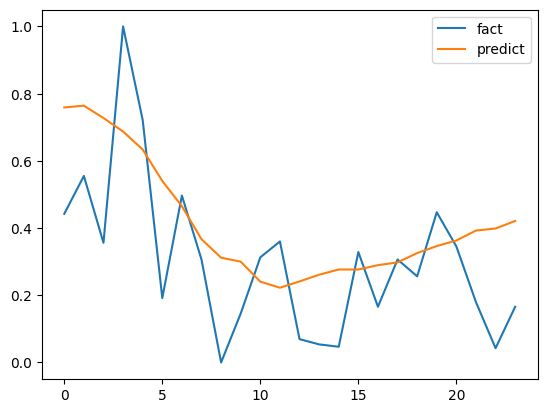

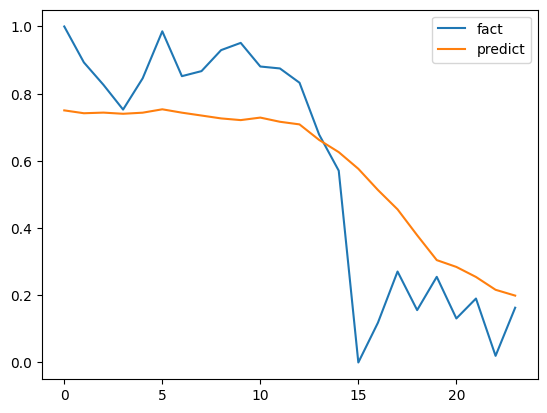

In [97]:
for _ in range(10):
    random_ind = random.randint(0, test_tensor.shape[0]-1)
    sample_data = test_tensor[random_ind]
    sample_predict = model(sample_data)
    
    plt.plot(sample_data, label='fact')
    plt.plot(sample_predict.detach().numpy(), label='predict')
    plt.legend()
    plt.show()

save model

In [98]:
torch.save(model.state_dict(), "clean_data/autoencoder_model.pth")

## нужен продуманный и прочаленный подход

train model

In [101]:
model = Autoencoder(24, nn.LeakyReLU())

In [102]:
train_params = {'optimizer': optim.Adam(model.parameters(), lr = 0.01),
                'criterion': nn.MSELoss(),
                'epochs': 500,
                'patience': 50
               }

In [103]:
batch_size = 64
train_loader = DataLoader(TensorDataset(train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(val_tensor), batch_size=batch_size, shuffle=False)

In [107]:
def train_model(model, train_loader, val_loader, train_params, to_plot=False):
    
    optimizer = train_params['optimizer']
    criterion = train_params['criterion']
    epochs = train_params['epochs']
    patience = train_params['patience']

    train_LOSS=[]
    val_LOSS = []
    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0
    
    for epoch in range(epochs):
        for data, in train_loader: 
            yhat=model(data)
            loss=criterion(yhat, data)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_output = model(val_tensor)
            val_loss = criterion(val_output, val_tensor)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            # Save the model state so far
            best_model_state = model.state_dict()
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                break

        Yhat = model(train_tensor)
        cur_loss = criterion(Yhat, train_tensor)
        train_LOSS.append(cur_loss.item())
    
        y_val = model(val_tensor)
        loss_val = criterion(y_val, val_tensor)
        val_LOSS.append(loss_val.item())

    #load best model state
    model.load_state_dict(best_model_state)
    model.eval()
    ypred = model(val_tensor)
    rmse = criterion(ypred, val_tensor).item() ** (1/2)
    print('Best val rmse: {}'.format(rmse))

    #plot training curve
    if to_plot:
        plt.plot(train_LOSS, label='train loss', linestyle='--')
        plt.plot(val_LOSS, label='val loss')
        plt.legend()
        plt.show()

    return model

Best val rmse: 0.20415251611471266


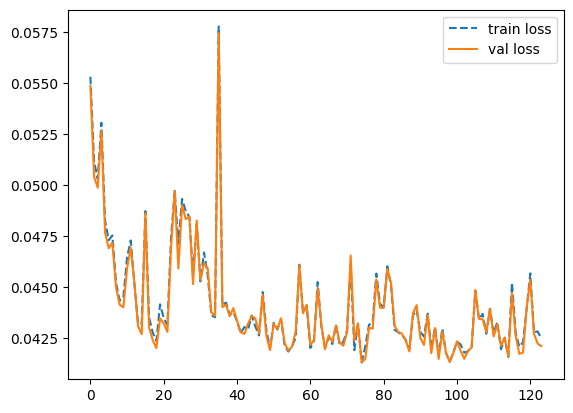

In [108]:
model = train_model(model, train_loader, val_loader, train_params, True)